## Import Dependencies and Data

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv('fetal_health.csv')

## Summarize Data

In [3]:
print('Dataframe head:\n', df.head(), '\n')
print('Dataframe tail:\n', df.tail(), '\n')
print('Data column summary statistics:\n', df.describe())

Dataframe head:
    baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                

Data Cleaning and Preprocessing
Handle Missing Values: Check for missing or zero values (which seem to be present in 'SkinThickness', 'Insulin', etc.) that may need to be imputed or handled appropriately.
Data Transformation: Normalize or standardize the continuous features such as Glucose, BloodPressure, BMI, etc., as they seem to be on different scales.
Categorical Encoding: If there are any categorical variables not included in the sample provided, they should be encoded properly using techniques like one-hot encoding.

In [ ]:
#drop hist features since they seem useless
columns_to_drop = [column for column in df.columns if 'histogram' in column.lower()]
cleaned_df = df.drop(columns=columns_to_drop)

# Display the first few rows of the dataframe to verify the columns have been dropped
cleaned_df.head()

Exploratory Data Analysis (EDA)
Statistical Summary: Generate descriptive statistics to understand the distribution of the data.
Correlation Analysis: Check the correlation between features to identify multicollinearity.
Visualization: Create visual plots (like histograms, box plots, scatter plots) to see the distribution of features and the relationship between features and the outcome.

In [4]:
# 1. Statistical Summary
statistical_summary = cleaned_df.describe()

# 2. Correlation Analysis
correlation_matrix = cleaned_df.corr()

(statistical_summary, correlation_matrix)

(       baseline value  accelerations  fetal_movement  uterine_contractions  \
 count     2126.000000    2126.000000     2126.000000           2126.000000   
 mean       133.303857       0.003178        0.009481              0.004366   
 std          9.840844       0.003866        0.046666              0.002946   
 min        106.000000       0.000000        0.000000              0.000000   
 25%        126.000000       0.000000        0.000000              0.002000   
 50%        133.000000       0.002000        0.000000              0.004000   
 75%        140.000000       0.006000        0.003000              0.007000   
 max        160.000000       0.019000        0.481000              0.015000   
 
        light_decelerations  severe_decelerations  prolongued_decelerations  \
 count          2126.000000           2126.000000               2126.000000   
 mean              0.001889              0.000003                  0.000159   
 std               0.002960              0.000057 

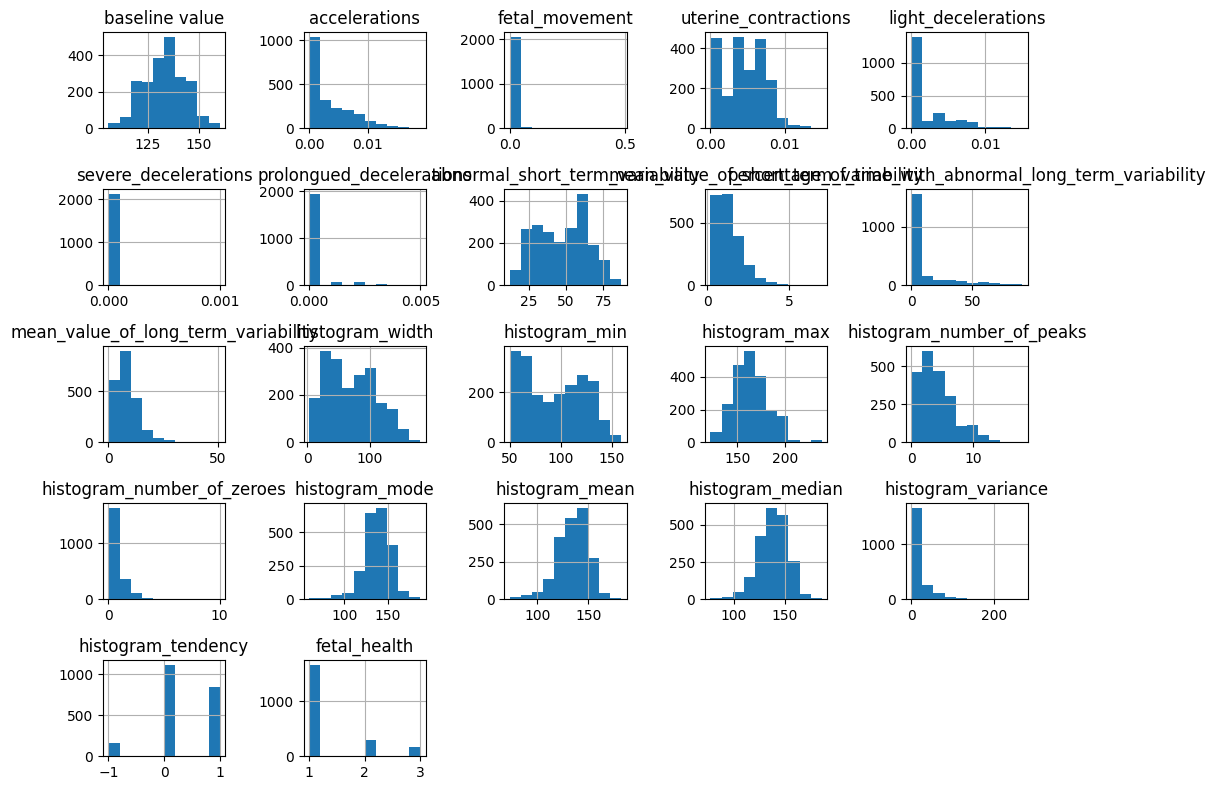

In [5]:
# Histograms for all features
cleaned_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

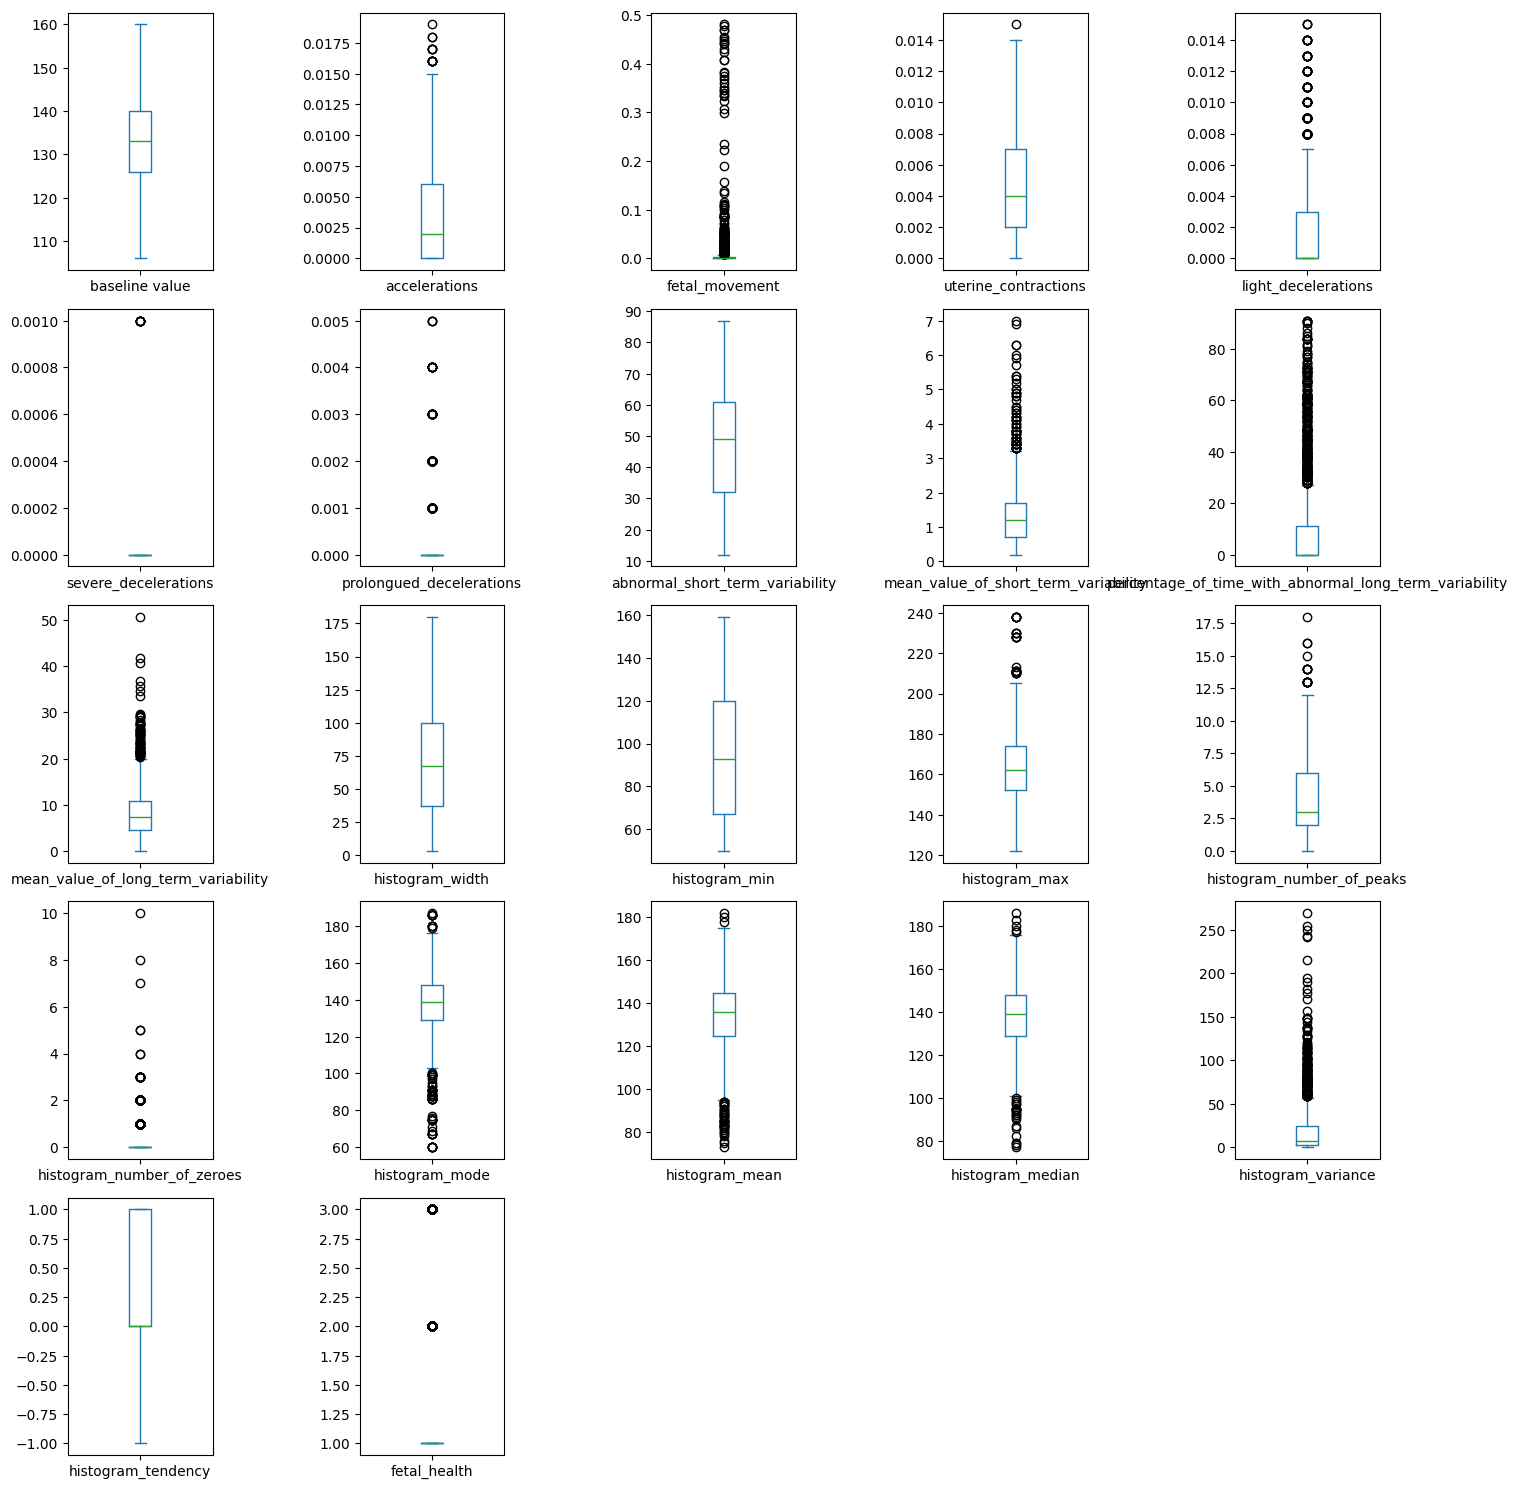

In [6]:
# Box plots for all features
cleaned_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(15, 15))
plt.tight_layout()
plt.show()

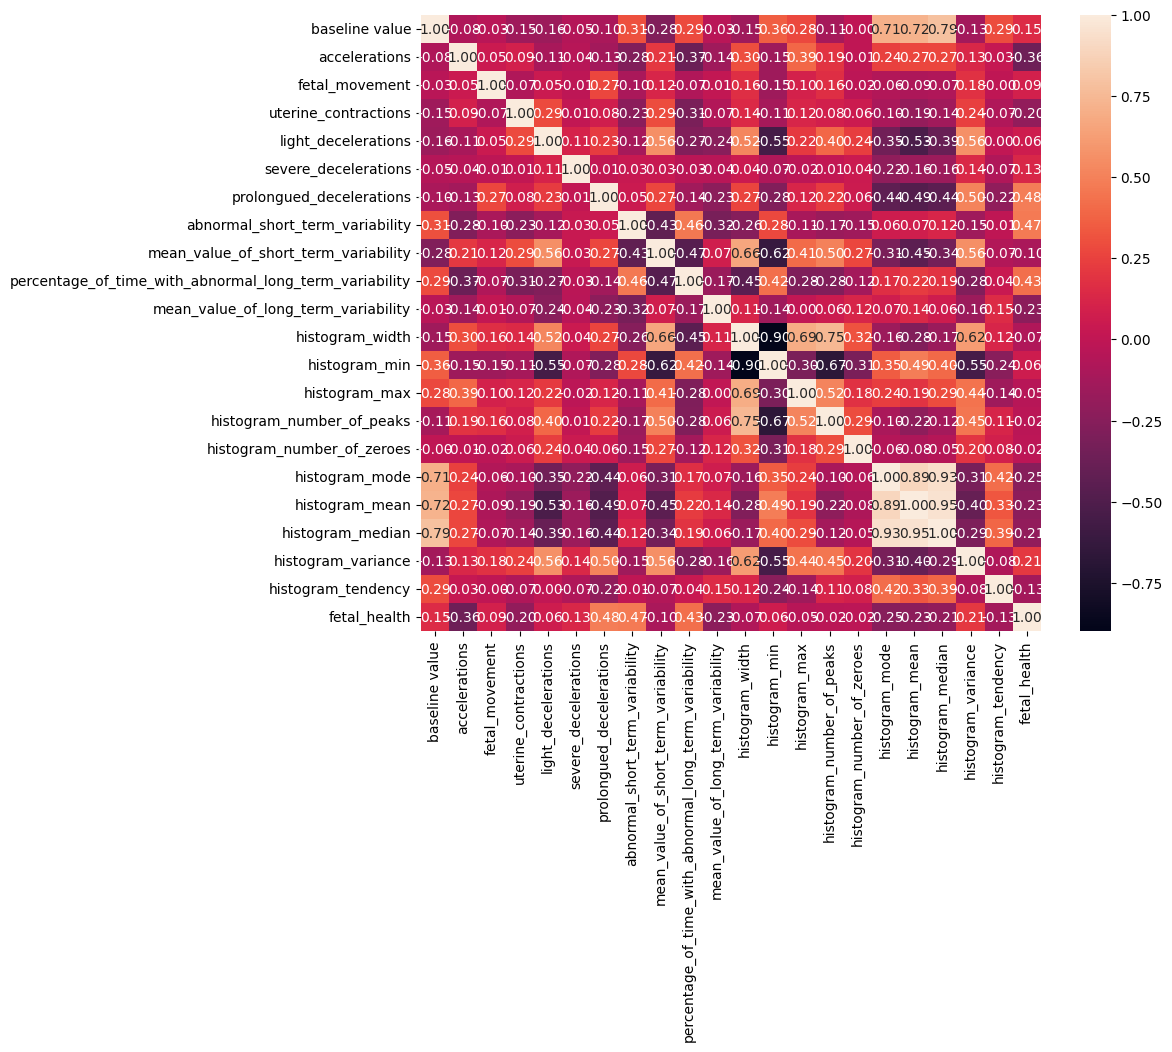

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_df.corr(), annot=True, fmt=".2f")
plt.show()

Model Selection

COMPARE TWO MODELS AND THEIR PERFORMANCE?

Model Training and Evaluation
Training: Train the model(s) on the training dataset.
Evaluation Metrics: Evaluate models using metrics such as accuracy, precision, recall, F1-score, ROC-AUC curve.

Validation
Validation Set: Evaluate the final model on a separate validation set that was not used during the model training phase to check for overfitting.
Learning Curves: Plot learning curves to diagnose if the model is learning well or if it's overfitting or underfitting.

Prediction and Interpretation
Make Predictions: Use the final model to make predictions on new data.
Interpret Results: Use tools like SHAP or LIME for model interpretation to understand how different features affect the outcome.

What features contributed most to the prediction?